In [28]:
#import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
from matplotlib.colors import LinearSegmentedColormap

#suppress warnings thrown by the libraries imported
warnings.filterwarnings('ignore')

#for now we are converting every column to object type and we will be changing the columns as per requirement
#this is done because it causes issues in the analysis as a lot of irrelevant data is present.
loan = pd.read_csv('loan.csv', dtype=object)
#Print dataframe shape to get the idea of rows and columns
#Print the information of the loan dataframe
#Print the data types of the loan dataframe
print(loan.shape)
print(loan.info())
print(loan.dtypes)

#remove duplicates
loan = loan.drop_duplicates(keep='first', subset='id')

(39717, 111)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: object(111)
memory usage: 33.6+ MB
None
id                            object
member_id                     object
loan_amnt                     object
funded_amnt                   object
funded_amnt_inv               object
                               ...  
tax_liens                     object
tot_hi_cred_lim               object
total_bal_ex_mort             object
total_bc_limit                object
total_il_high_credit_limit    object
Length: 111, dtype: object


In [29]:
#check number of empty rows, axis = 1 for rows
print(loan.isnull().all(axis = 1).sum())
#check number of empty columns, axis = 0 for columns
print(loan.isnull().all(axis = 0).sum())

#check number of columns with all null values
loan.isnull().sum()

#remove all the columns where most of the values are null
#this will be done for the indices from 53 inclusive to 105 exclusive
loan.drop(loan.iloc[:, 53:105], inplace = True, axis = 1) 

#remove other columns which are not required or mostly contain null values
#this will be done by column name
columns_to_drop = ['desc', 'mths_since_last_delinq', 'mths_since_last_record','next_pymnt_d','tot_hi_cred_lim']
columns_to_drop.extend(['mths_since_last_major_derog','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit'])
columns_to_drop.extend(['member_id','url','emp_title','zip_code','tax_liens'])
loan.drop(labels=columns_to_drop, inplace = True, axis = 1)

0
54


In [30]:
#Print dataframe shape to get the idea of rows and columns
#Print the information of the loan dataframe
print(loan.shape)

#clean up
#remove % symbol from interest rate and revolving line utilization rate
loan['int_rate'] = loan['int_rate'].str.rstrip('%').astype('float')
loan['revol_util'] = loan['revol_util'].str.rstrip('%').astype('float')
#extract digit from employment length
loan['emp_length'].fillna('0', inplace=True)
loan['emp_length'] = loan['emp_length'].str.extract('(\d+)').astype('int')
print(loan.info())

(39717, 45)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  object 
 1   loan_amnt                   39717 non-null  object 
 2   funded_amnt                 39717 non-null  object 
 3   funded_amnt_inv             39717 non-null  object 
 4   term                        39717 non-null  object 
 5   int_rate                    39717 non-null  float64
 6   installment                 39717 non-null  object 
 7   grade                       39717 non-null  object 
 8   sub_grade                   39717 non-null  object 
 9   emp_length                  39717 non-null  int32  
 10  home_ownership              39717 non-null  object 
 11  annual_inc                  39717 non-null  object 
 12  verification_status         39717 non-null  object 
 13  issue_d            

In [31]:
#clean up bankruptcies
#replace null/na values with 'unknown'
print(loan['pub_rec_bankruptcies'].isnull().sum())
loan['pub_rec_bankruptcies'].fillna('unknown', inplace=True)

697


In [32]:
#Maybe we will require month and year column for the analysis so adding those two.
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format='%b-%y')
loan['issue_year'] = loan['issue_d'].dt.year
loan['issue_month'] = loan['issue_d'].dt.month

In [33]:
#analysing status of loan as it's one of the most important variables
print(round((loan['loan_status'].value_counts() * 100) / len(loan), 2))

#findings
#---------------------------------------------------
#almost 83 percent people has fully paid their loans
#14 percent has defaulted.
#3 percent are in the process of paying.
#---------------------------------------------------

#analysing purpose of loan
print(round((loan['purpose'].value_counts() * 100) / len(loan), 2))


loan_status
Fully Paid     82.96
Charged Off    14.17
Current         2.87
Name: count, dtype: float64
purpose
debt_consolidation    46.93
credit_card           12.92
other                 10.05
home_improvement       7.49
major_purchase         5.51
small_business         4.60
car                    3.90
wedding                2.38
medical                1.74
moving                 1.47
vacation               0.96
house                  0.96
educational            0.82
renewable_energy       0.26
Name: count, dtype: float64


In [34]:
#Custom method for describing and box plotting a variable
def describe_and_boxplot(df):
    """
        :Prints the description of the column and plots a boxplot for the same column.
        :param df: column whose description is to be printed
    """
    print(df.describe())
    sns.boxplot(df)
    plt.show()

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


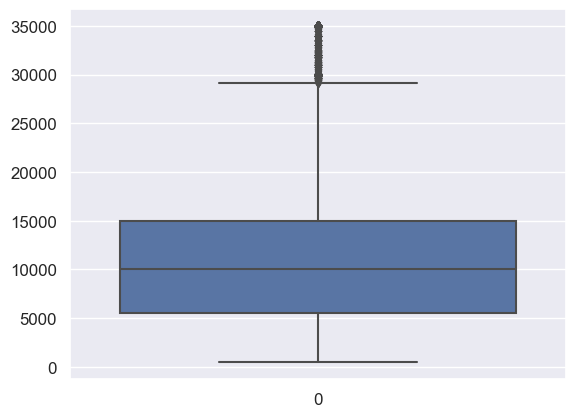

In [35]:
#Univariate Analysis

#convert the required variables to numeric type
numeric_cols = ['loan_amnt','funded_amnt','int_rate','funded_amnt_inv','installment','annual_inc','dti','emp_length','total_pymnt']
loan[numeric_cols] = loan[numeric_cols].apply(pd.to_numeric)

#Loan Amount
describe_and_boxplot(loan['loan_amnt'])

#seems like Loan amount is already consistent and doesn't have any outliers

count    39717.000000
mean     12153.596544
std       9042.040766
min          0.000000
25%       5576.930000
50%       9899.640319
75%      16534.433040
max      58563.679930
Name: total_pymnt, dtype: float64


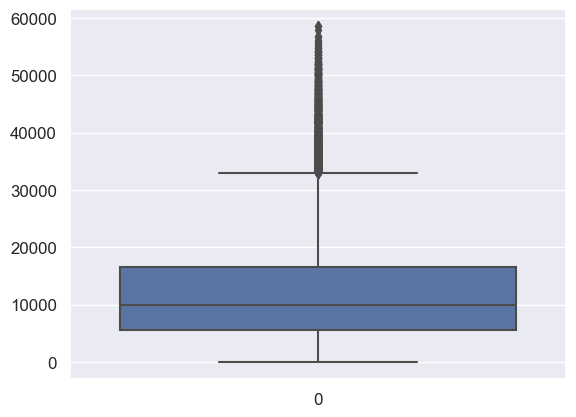

In [36]:
#Total Payment
describe_and_boxplot(loan['total_pymnt'])

#seems like Loan amount is already consistent and doesn't have any outliers

In [37]:
def remove_outliers(ds, column, min_percentile, max_percentile):
    """
        Removes outliers from a given column
        :param ds: dataframe which contains the column
        :param column: column from which outliers should be removed
        :param min_percentile: minimum percentile above which data is consistent
        :param max_percentile: maximum percentile below which data is consistent

        :Returns the dataframe after removing outliers from it.
    """
    max_percentile_limit = ds[column].quantile(max_percentile)
    min_percentile_limit = ds[column].quantile(min_percentile)
    return ds[((ds[column] > min_percentile_limit) & (ds[column] < max_percentile_limit))]

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64


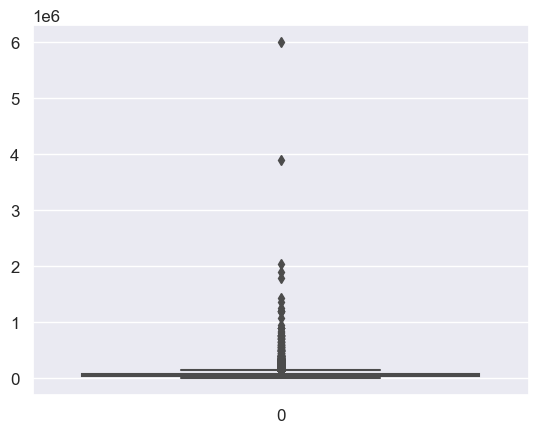

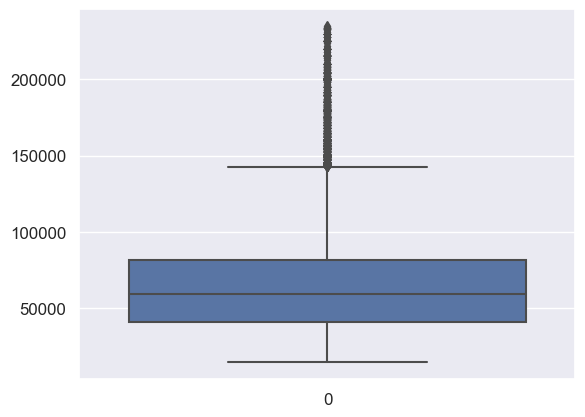

In [38]:
#Annual Income
describe_and_boxplot(loan['annual_inc'])


#Seems like data has outliers and we have to remove those outliers
loan = remove_outliers(loan, 'annual_inc', 0.01, 0.99)
#After removing outliers
sns.boxplot(loan['annual_inc'])
plt.show()

count    38897.000000
mean        12.010275
std          3.722155
min          5.420000
25%          9.250000
50%         11.830000
75%         14.540000
max         24.590000
Name: int_rate, dtype: float64


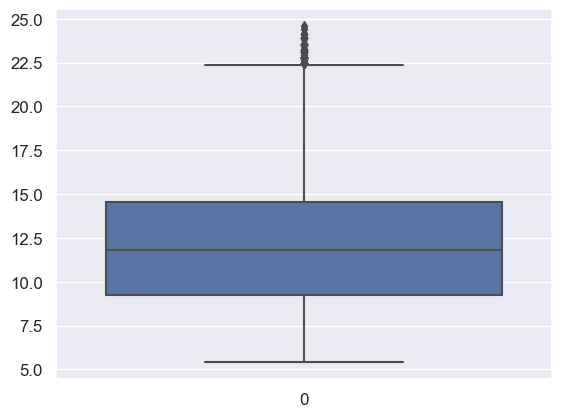

In [39]:
#Interest Rate
describe_and_boxplot(loan['int_rate'])
#Seems like interest rate doesn't have any outliers

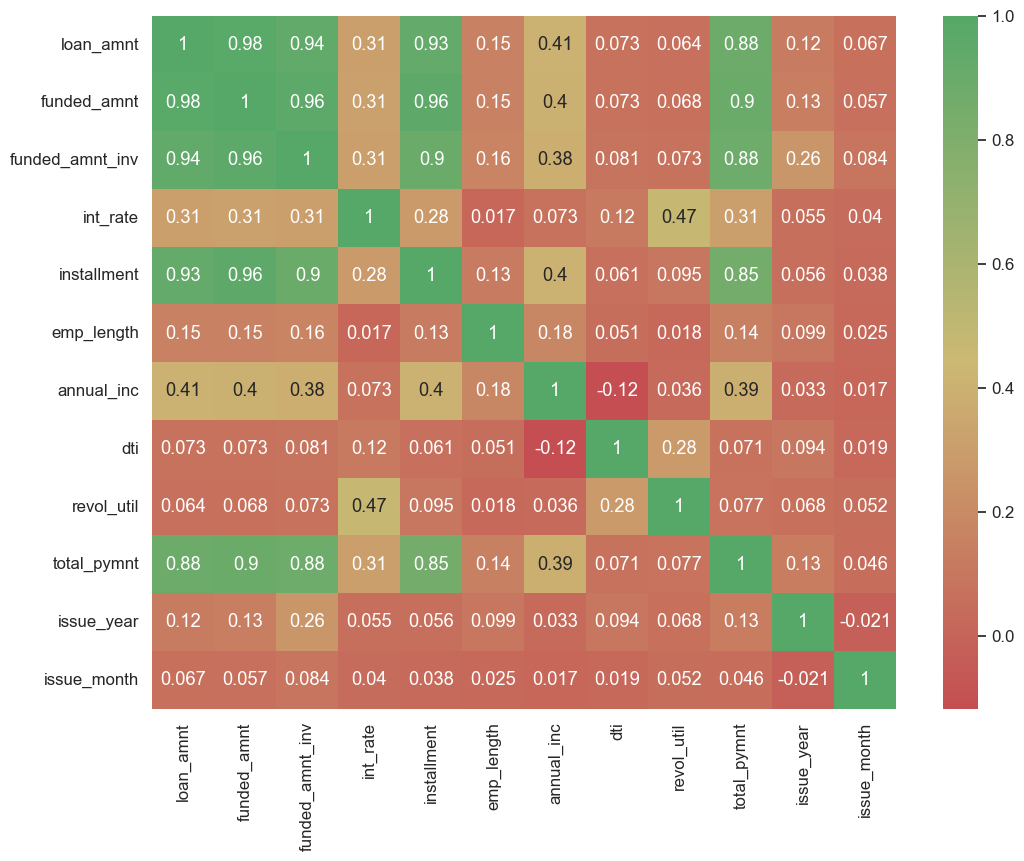

In [43]:
loan_correlation_data = loan.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.1)
color_scheme = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)
sns.heatmap(loan_correlation_data,cmap = color_scheme, ax=ax, annot=True)
plt.show()

#------------FINDINGS----------------
# NOTE
#1. positive correlation means when one variable increases the other variable also increases with it.
#2. negative correlation means when one variable increases the other variable decreases with it.
#3. DTI is Debt To Income ratio, means its the percentage of applicant's income that goes towards the loan repayment.


#1. Loan amount, Funded amount and Investor's Funding amount are strongly correlated
#2. DTI is slightly negatively correlated with the annual income.
#3. Positive relation between employement years and annual income.